### Newtons Method

#### The Standard Assumptions

1. $f$ is twice differentiable

$$||\nabla^2f(x) - \nabla^2f(y)|| \leq \gamma |x-y|$$

2. At the minimum point $x^{*}$,
$$\nabla f(x^{*}) = 0$$

3.  At the minimum point $x^{*}$,
$$\nabla^2 f(x^{*}) \text{ is positive definite}$$

#### Why it is used

- Quadratic convergence if the standard assumptions are met.

#### How it works: The 1D Case
In the one dimensional case, the algorithm simply extends the tangent line of the derivative to the x-axis. If the estimate is sufficiently close to zero, the iteration stops. If not, the new guess is where the tangent line meets the x-axis. The plot below provides a good demo of one iteration.

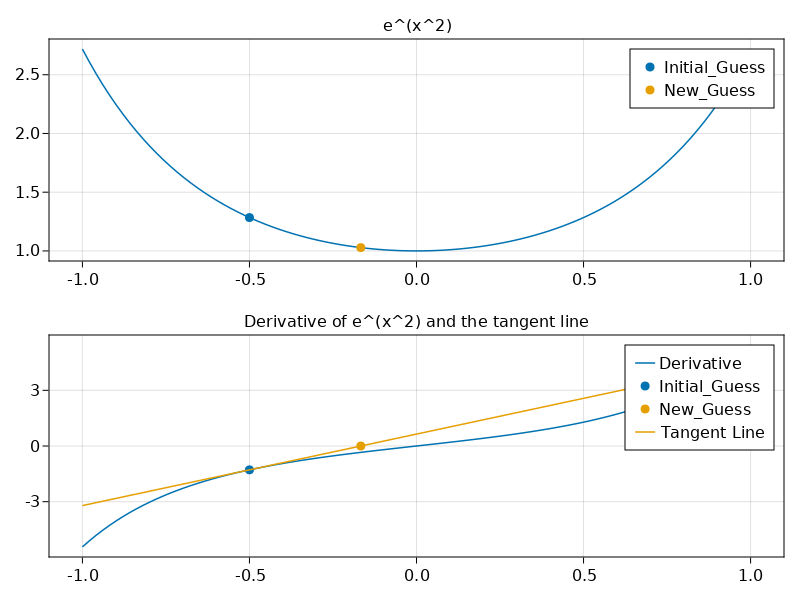

In [1]:
using CairoMakie

function demo_plot(convex_function::Function, derivative::Function, Derivative_2nd::Function,
    initial_guess::Float64, function_string::String; x_min::Float64 = -1.0, 
    x_max::Float64 = 1.0, points::Int64 = 100)
    """
    This function shows one iteration of Newtons Method given the described inputs
    Inputs:
        convex_function: our convex function we wish to minimize
        derivative: the derivative of convex function
        2nd derivative: the 2nd derivative of the convex function
    Outputs:
        figure 
    """
    #Calculate the next guess
    guess = -(derivative(initial_guess)/Derivative_2nd(initial_guess)) + initial_guess

    #Create Figure and X_Space

    f = Figure()
    x::Array{Float64} = LinRange(x_min,x_max,100)

    #Plot the function and the initial guess and new guess 

    ax = Axis(f[1,1], title = function_string)
    y_vals::Array{Float64} = map(convex_function, x)
    lines!(ax, x, y_vals)
    scatter!(ax, [initial_guess], [convex_function(initial_guess)], label= "Initial_Guess")
    scatter!(ax, [guess], [convex_function(guess)], label = "New_Guess")
    axislegend()

    #Plot the derivative, the tangent line, and the guesses on a separate plot

    ax2 = Axis(f[2,1], title = "Derivative of $(function_string) and the tangent line")
    derivative_vals::Array{Float64} = map(derivative, x)
    lines!(ax2, x, derivative_vals, label = "Derivative")
    scatter!(ax2, [initial_guess], [derivative(initial_guess)], label= "Initial_Guess")
    scatter!(ax2, [guess], [0], label = "New_Guess")
    tan_vals::Array{Float64} = map((x) -> Derivative_2nd(initial_guess)*(x - initial_guess) + derivative(initial_guess), x)
    lines!(ax2, x, tan_vals, label = "Tangent Line")
    axislegend()

    return f
end

function exponential_x2(x)
    return exp(x^2)
end

function der_exponential_x2(x)
    return 2*x*exp(x^2)
end

function der2_exponential_x2(x)
    return 4*x^2*exp(x^2) + 2*exp(x^2)
end

display(demo_plot(exponential_x2, der_exponential_x2, der2_exponential_x2, -0.5, "e^(x^2)"))

The next code implements newtons method in the one dimensional case.

In [2]:
function Newtons1D(convex_function::Function, derivative::Function, Derivative_2nd::Function,
    initial_guess::Float64; abs_tol::Float64 = 1e-10, rel_tol::Float64 = 1e-10, max_iter::Int64 = 50)

    guess = initial_guess
    Guess_Array = Array{Float64}(undef, max_iter+1, 2)
    Guess_Array[1,1] = guess
    Guess_Array[1,2] = abs(derivative(guess))
    tol = rel_tol * abs(derivative(initial_guess)) + abs_tol
 
    for i in 1:max_iter 
        #Calculate the next guess
        guess = -(derivative(guess)/Derivative_2nd(guess)) + guess
        Guess_Array[i+1,1] = guess
        Guess_Array[i+1,2] = abs(derivative(guess))

        if Guess_Array[i+1,2] <= tol
            return Guess_Array[1:i+1,:]
        end
    end
    println("""Tolerance not achieved\n 
            Current Derivative Error: $(Guess_Array[end, 2])\n
            Current Guess: $(Guess_Array[end, 1])\n
            """)
    return Guess_Array
end

Newtons1D(exponential_x2, der_exponential_x2, der2_exponential_x2, 4.0)

22×2 Matrix{Float64}:
 4.0             7.10889e7
 3.87879         2.65268e7
 3.75403         9.9065e6
 3.6254          3.70297e6
 3.49254         1.38555e6
 3.35501         5.19035e5
 3.21232         1.94689e5
 3.06387     73137.3
 2.90893     27523.0
 2.74663     10378.6
 2.5759       3923.08
 2.3954       1487.18
 2.2034        565.724
 1.99766       216.109
 1.77524        82.9762
 1.53215        32.0506
 1.26312        12.4559
 0.961725        4.85027
 0.624257        1.84347
 0.273432        0.589317
 0.0355678       0.0712255
 8.97639e-5      0.000179528

The next code creates a gif of the process. 

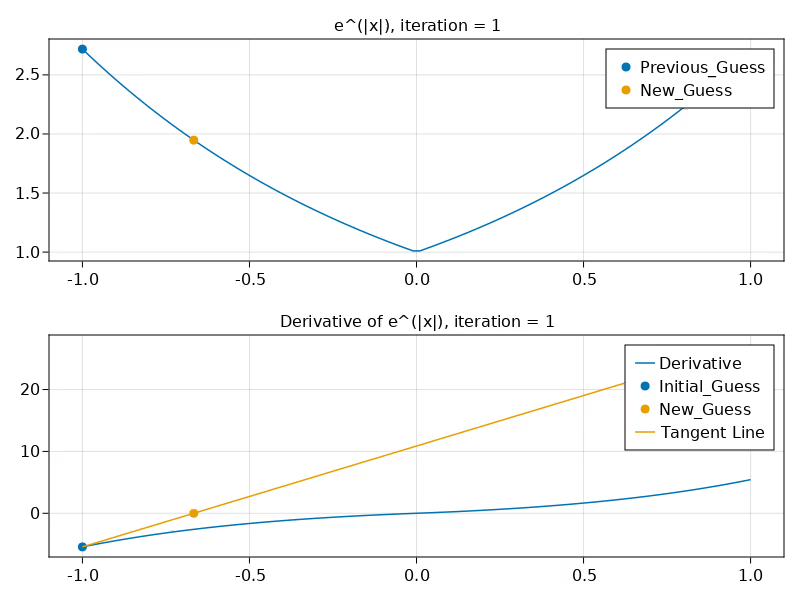

In [25]:
function newton_gif(convex_function::Function, derivative::Function, Derivative_2nd::Function,
    initial_guess::Float64, function_string::String, path::String; x_min::Float64 = -1.0, 
    x_max::Float64 = 1.0, points::Int64 = 100, abs_tol::Float64 = 1e-10, 
    rel_tol::Float64 = 1e-10, max_iter::Int64 = 50)
    """
    This function shows one iteration of Newtons Method given the described inputs
    Inputs:
        convex_function: our convex function we wish to minimize
        derivative: the derivative of convex function
        2nd derivative: the 2nd derivative of the convex function
    Outputs:
        figure 
    """
    #Perform Newtons
    newton_data = Newtons1D(convex_function, derivative, Derivative_2nd, initial_guess; abs_tol=abs_tol, rel_tol = rel_tol, max_iter = max_iter)
    newton_iter = 1:size(newton_data)[1]

    #Create Figure,Observable and X_Space
    f = Figure()
    obs = Observable{Int64}(1)
    x::Array{Float64} = LinRange(x_min,x_max,100)
    guess = @lift(newton_data[$obs + 1,1])
    prev_guess = @lift(newton_data[$obs,1])
    iter_num = @lift(newton_iter[$obs])

    #Plot the function and the initial guess and new guess 

    ax = Axis(f[1,1], title = @lift("$(function_string), iteration = $($iter_num)"))
    y_vals::Array{Float64} = map(convex_function, x)
    lines!(ax, x, y_vals)
    scatter!(ax, @lift([$prev_guess]), @lift([convex_function($prev_guess)]), label= "Previous_Guess")
    scatter!(ax, @lift[$guess], @lift([convex_function($guess)]), label = "New_Guess")
    axislegend()

    #Plot the derivative, the tangent line, and the guesses on a separate plot
    
    ax2 = Axis(f[2,1], title = @lift("Derivative of $(function_string), iteration = $($iter_num)"))
    derivative_vals::Array{Float64} = map(derivative, x)
    lines!(ax2, x, derivative_vals, label = "Derivative")
    scatter!(ax2, @lift([$prev_guess]), @lift([derivative($prev_guess)]), label= "Initial_Guess")
    scatter!(ax2, @lift([$guess]), [0], label = "New_Guess")
    tan_vals::Array{Float64, 2} = [Derivative_2nd(p)*(x - p) + derivative(p) for p in newton_data[:,1], x in x]
    tan = @lift(tan_vals[$obs, :])
    lines!(ax2, x, tan, label = "Tangent Line")
    axislegend()
    
    #define the framerate
    framerate::Int64 = 1

    #Create GIF
    record(f, path, newton_iter[1:end-1]; framerate = framerate) do t
    obs[] = t
    end
 
    if path[end-3:end] == ".gif"
        display(MIME"image/png"(), read(open(path)))
    end
end

function exponential_abs(x)
    return exp(abs(x))
end

function der_exponential_abs(x)
    return 2*x*exp(abs(x))
end

function der2_exponential_abs(x)
    return 4*x^2*exp(abs(x)) + 2*exp(abs(x))
end

newton_gif(exponential_abs, der_exponential_abs, der2_exponential_abs, -1.0, "e^(|x|)", "newton.gif";)

### How it works: Multiple dimensional case
Instead of extending a tangent line from the derivative, we minimize the local quadratic model defined in the following way:
$$m_{n}(x) = f(x) + \nabla f(x)^T(x - x_{n}) + \frac{1}{2}(x - x_{n})^T \nabla^2f(x_{n})(x-x_{n})$$
Since, the hessisian is positice definite, this occurs at
$$x_{n+1} = x_n + (\nabla^2f(x_{n}))^{-1} \nabla f(x_n)$$
In practice, we solve the equation
$$\nabla^2f(x_{n}))s  = -1 \times \nabla f(x_n)$$
Then, our next point $x_{n+1} = x_n + s$.

The code below implements this method using Julia's autodifferentiation library to calculate hessians and gradients.


In [3]:
using LinearAlgebra
using ForwardDiff
using Random

In [67]:
function Newtons(f, initial_guess; 
    abs_tol::Float64 = 1e-16, rel_tol::Float64 = 1e-14, max_iter::Int64 = 50)

    #Define the gradient and hessian functions using Julia's ForwardDiff (done via autodifferentiation)

    gradient = x -> ForwardDiff.gradient(f, x)
    hessian = x -> ForwardDiff.hessian(f, x)
    
    #Initialize with initial_guess
    guess = initial_guess
    Guess_Array = Array{Any}(undef, max_iter+1, 2)
    Guess_Array[1,1] = guess
    Guess_Array[1,2] = norm(gradient(guess), 2)
    tol = rel_tol * Guess_Array[1,2] + abs_tol
    
    #Iterate
    for i in 1:max_iter 
        #Calculate the next guess
        s = hessian(guess) \ (-1* gradient(guess))
        guess = guess + s
        #Update our return Array
        Guess_Array[i+1, 1] = guess
        Guess_Array[i+1, 2] = norm(gradient(guess),2)
        if Guess_Array[i+1,2] <= tol
            return Guess_Array[1:i+1,:]
        end
    end
    println("""Tolerance not achieved\n 
            Current Derivative Error: $(Guess_Array[end, 2])\n
            Current Guess: $(Guess_Array[end, 1])\n
            """)
    return Guess_Array
end

function ex(x::Vector)
    k = x'*x
    return exp(k)
end


ex (generic function with 1 method)

In [54]:
nums = 2 .* rand(Float64, 2) .- 1
nums = nums/norm(nums,2)
a = Newtons(ex, nums;abs_tol = 1e-14)
display(a)
display(norm(a[end, 1], 2))

7×2 Matrix{Any}:
 [-0.586383, -0.810034]        5.43656
 [-0.390922, -0.540023]        2.0795
 [-0.183963, -0.254128]        0.692348
 [-0.0302567, -0.0417969]      0.103473
 [-0.000160261, -0.000221385]  0.000546607
 [-2.39413e-11, -3.30727e-11]  8.16576e-11
 [0.0, 0.0]                    0.0

0.0

This method works for higher dimensions as well

In [55]:
nums = 2 .* rand(Float64, 100) .- 1
nums = nums/norm(nums,2)
a = Newtons(ex, nums;abs_tol = 1e-14)
display(a)
display(norm(a[end, 1], 2))

7×2 Matrix{Any}:
 [0.0538018, 0.0556084, 0.0947665, 0.174513, -0.0198546, 0.0315293, -0.00532938, 0.0129445, -0.0704284, -0.0491  …  -0.0952675, 0.128937, 0.0813251, 0.164628, 0.0191492, 0.0405472, 0.126427, -0.0960646, -0.0948021, 0.119558]                                            …  5.43656
 [0.0358678, 0.0370723, 0.0631777, 0.116342, -0.0132364, 0.0210195, -0.00355292, 0.00862968, -0.0469523, -0.0327333  …  -0.0635116, 0.085958, 0.0542168, 0.109752, 0.0127662, 0.0270315, 0.0842844, -0.0640431, -0.0632014, 0.0797053]                                         2.0795
 [0.016879, 0.0174458, 0.0297307, 0.0547491, -0.00622891, 0.00989155, -0.00167196, 0.00406103, -0.0220952, -0.0154039  …  -0.0298878, 0.0404508, 0.0255138, 0.0516479, 0.0060076, 0.0127207, 0.0396633, -0.0301379, -0.0297418, 0.0375084]                                     0.692348
 [0.00277611, 0.00286934, 0.00488985, 0.00900466, -0.00102448, 0.00162688, -0.00027499, 0.000667924, -0.00363403, -0.00253351  …  -0.0049157, 0.00

0.0

### Termination of the iteration
In previous iterations, we either terminate the algorithm when $\tau$ is sufficiently small where $\tau$ is defined as the following:
$$\tau = \tau_{relative}||\nabla f(x_0)|| + \tau_{absolute}$$
The absolute term is added just as a safeguard against floating point errrors preventing the algorithm from converging at low gradient values. So, this begs the question, does the relative gradient converging to zero imply that $lim_{n\rightarrow \infty}||minimum - x_n|| = 0.$ If the hessian of the matrix is well conditioned, then small gradient norm implies small error norm. Lets look at two functions with different condition numbers. First, we have our original function $f(\bold{x}) = e^{\bold{x}^{T}  \bold{x}}$. Next, we have $f(\bold{x}) = e^{||\bold{x}||_{10}^{10}}$ where $||\cdot ||_{10}$ is the $L_{10}$ norm. Lets look at the condition number of the hessian for the 100 dimensional case at various distances from 0.

In [62]:
function ex10(x::Vector)
    k = norm(x, 10)^10
    return exp((k))
end

input_distance = [32.0 * 2.0^(-1*i) for i in 1:8]
hessian_ex = (x) -> ForwardDiff.hessian(ex, x)
hessian_ex10 = (x) -> ForwardDiff.hessian(ex10, x)

for i in input_distance
    println("Distance is $(i)")
    input = (2 .* rand(Float64, 100) .- 1)
    input = input/(norm(input,2)*i)
    println("Hessian condition number for function one is $(cond(hessian_ex(input)))")
    println("Hessian condition number for function two is $(cond(hessian_ex10(input)))")
    print("\n\n\n\n")
end

Distance is 16.0
Hessian condition number for function one is 1.0078125000000009
Hessian condition number for function two is 9.645126500119067e16




Distance is 8.0
Hessian condition number for function one is 1.0312500000000007
Hessian condition number for function two is 4.697256503337202e19




Distance is 4.0
Hessian condition number for function one is 1.1250000000000007
Hessian condition number for function two is 7.929019527379535e14




Distance is 2.0
Hessian condition number for function one is 1.5000000000000022
Hessian condition number for function two is 2.073841150402853e15




Distance is 1.0
Hessian condition number for function one is 3.0000000000000004
Hessian condition number for function two is 5.929063398860092e17




Distance is 0.5
Hessian condition number for function one is 9.000000000000009
Hessian condition number for function two is 7.317082866601502e15




Distance is 0.25
Hessian condition number for function one is 33.00000000000002
Hessian condition nu

Now, lets compare the newton's method accuracy for both

In [63]:
display("Newton's for the low condition number hessian function")
nums = 2 .* rand(Float64, 100) .- 1
nums = nums/norm(nums,2)
a = Newtons(ex, nums;abs_tol = 1e-14)
display("Distance from minimum:")
display(norm(a[end, 1], 2))

display("Newton's for the high condition number hessian function")
a = Newtons(ex10, nums;abs_tol = 1e-14)
display("Distance from minimum:")
display(norm(a[end, 1], 2))

"Newton's for the low condition number hessian function"

"Distance from minimum:"

0.0

"Newton's for the high condition number hessian function"

"Distance from minimum:"

0.10668468876058314

As can be seen, if the condition number of the hessian is poorly conditioned we will run into errors.

### Numerical evidence of convergence rate

The theory says we should see order 2 convergence. If we compare the distance away from the minimum from one iteration to the next, we should see the distance decrease by a factor of $1/4$. The code below shows a demo.


In [83]:
using DataFrames

function convergence_demo(func::Function, initial_data::Vector{Float64}; minimum = 0,
    abs_tol::Float64 = 1e-16, rel_tol::Float64 = 1e-14, max_iter::Int64 = 50)

    #Calculate the points in Newtons Method
    newton_data = Newtons(func, initial_data; abs_tol = abs_tol, rel_tol = rel_tol, 
    max_iter = max_iter)
    #Initialize minimum if at zero
    if minimum == 0
        minimum = zeros(Float64, length(newton_data[1,1]))
    end
    
    #Calculate the gradient at each point
    gradient = x -> ForwardDiff.gradient(func, x)
    distances::Array{Float64} = [norm(gradient(x),2) for x in newton_data[:,1]]
    iteration_list = 1:length(newton_data[:,1])
    Relative_Distance::Array{Union{Float64,String}} = [if i !=1
                                                        distances[i]/distances[i-1]
                                                    else
                                                        "XXXXXXXX"
                                                    end
                                                    for i in 1:length(distances)]
    #Create DF
    df = DataFrame(Iteration = iteration_list, Distance = distances, Relative_Distance = Relative_Distance)

    return df


end

nums = 2 .* rand(Float64, 2) .- 1
nums = nums/norm(nums,2)
a = convergence_demo(ex, nums)
display(a)

,Iteration,Distance,Relative_Distance
,Int64,Float64,Union…
1,1,5.43656,XXXXXXXX
2,2,2.0795,0.382502
3,3,0.692348,0.33294
4,4,0.103473,0.149452
5,5,0.000546607,0.00528261
6,6,8.16576e-11,1.4939e-7
7,7,0.0,0.0


As can be seen, we see under or near 0.25 for all the iterations

### Inexact Newton's Methods

Instead of perfectly solving 
$$\nabla^2f(x_{n}))s  = -1 \times \nabla f(x_n)$$
We can instead use an inexact newton's method that satisfies the following,
$$||\nabla^2f(x_{n}))s -1 \times \nabla f(x_n)|| \leq \eta_n||\nabla f(x_n)|| \text{ where } 0 \leq \eta_{n} < 1$$
If $$lim_{n \rightarrow \infty} \eta_{n} = 0$$, then the method is guaranteed to converge super-linearly. Specifically, if $\eta_{n} \leq K||\nabla f(x_n)||^P$, then the method converges at a rate $1+P$. One example of this is Newton CG which will be implemented on another summary